## <span style=color:blue>Illustrations of accessing and using GAEZ data</span>

<span style=color:blue>First some initialization</span>

In [37]:
# These are boiler plate imports that seem useful
# I should probably delete or comment out the ones that aren't used in this script...

import sys
import os
import subprocess
import shutil
# use shutil.rmtree(<path_to_folder>) to do an rm -r on the folder

import json
import csv
import yaml

import urllib

import pandas as pd
import numpy as np

import matplotlib as mpl
from cycler import cycler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# sys.path.append('/Users/rick/HACKING/UTILITIES_IN_HACKING/')
# import utils_general


# this one gives a warning - not fixing for now
# from owlready2 import *

# next function is used to generate timestamps that can be used to
# create uniquely named directories and/or files
import datetime
def curr_timestamp():
    current_datetime = datetime.datetime.now()
    formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
    return formatted_datetime


print('Initial imports successful')

Initial imports successful


### <span style=color:blue>Fetching a .tif file using urllib.</span>

In [38]:
# Using the URL of TIF file Land and Water Resources / Land Cover / Cropland 
url = "https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/LR/lco/GLCSv11_02_5m.tif"

# Local directory to save the TIF file in
dir = "/Users/rick/AG-CODE--v02/GAEZ--v02/"
tif_file_name = "cropland.tif"

# Fetch the TIF file using the URL
urllib.request.urlretrieve(url, dir + tif_file_name)

('/Users/rick/AG-CODE--v02/GAEZ--v02/cropland.tif',
 <http.client.HTTPMessage at 0x164690c10>)

### <span style=color:blue>Fetching meta-data about the .tif file using GDAL, in particular the command-line operator gdalinfo.</span>

In [39]:
val = " ".join(["gdalinfo", "-json", dir + tif_file_name])
print(val)
result = subprocess.run([val], shell=True, capture_output=True, text=True)

dict = json.loads(result.stdout)
print(json.dumps(dict, indent=2, sort_keys=True))

gdalinfo -json /Users/rick/AG-CODE--v02/GAEZ--v02/cropland.tif
{
  "bands": [
    {
      "band": 1,
      "block": [
        512,
        512
      ],
      "colorInterpretation": "Palette",
      "metadata": {},
      "overviews": [
        {
          "size": [
            2160,
            1080
          ]
        },
        {
          "size": [
            1080,
            540
          ]
        },
        {
          "size": [
            540,
            270
          ]
        },
        {
          "size": [
            270,
            135
          ]
        },
        {
          "size": [
            135,
            68
          ]
        },
        {
          "size": [
            68,
            34
          ]
        }
      ],
      "type": "Float32",
      "unit": "unspecified"
    }
  ],
  "coordinateSystem": {
    "dataAxisToSRSAxisMapping": [
      2,
      1
    ],
    "wkt": "GEOGCRS[\"WGS 84\",\n    ENSEMBLE[\"World Geodetic System 1984 ensemble\",\n       

In [40]:
def pull_useful(ginfo):  # should give as input the result.stdout from calling gdalinfo -json
    useful = {}
    useful['cornerCoordinates'] = ginfo['cornerCoordinates']
    useful['proj:transform'] = ginfo['stac']['proj:transform']
    useful['size'] = ginfo['size']
    useful['bbox'] = ginfo['stac']['proj:projjson']['bbox']
    useful['espgEncoding'] = ginfo['stac']['proj:epsg']
    return useful


useful = pull_useful(dict)
print(json.dumps(useful, indent=2, sort_keys=True))

{
  "bbox": {
    "east_longitude": 180,
    "north_latitude": 90,
    "south_latitude": -90,
    "west_longitude": -180
  },
  "cornerCoordinates": {
    "center": [
      0.0,
      0.0
    ],
    "lowerLeft": [
      -180.0,
      -90.0
    ],
    "lowerRight": [
      180.0,
      -90.0
    ],
    "upperLeft": [
      -180.0,
      90.0
    ],
    "upperRight": [
      180.0,
      90.0
    ]
  },
  "espgEncoding": 4326,
  "proj:transform": [
    -180.0,
    0.0833333333333333,
    0.0,
    90.0,
    0.0,
    -0.0833333333333333
  ],
  "size": [
    4320,
    2160
  ]
}


### <span style=color:blue>Fetching value of a pixel using gdallocationinfo.</span>

<span style=color:blue>Note: this .tif has one "Band".  In some casesjl, .tif files have multiple bands, which hold separate parts of the overall data.</span>

In [49]:
# converting from lat/long into a pixel location for a global tif with size 4320x2160
def convert_to_pix(lon, lat):
    x = (lon + 180) * 12
    y = (90 - lat) * 12
    return x,y

dir = "/Users/rick/AG-CODE--v02/GAEZ--v02/"
tif_file_name = "cropland.tif"


# x,y = convert_to_pix(-121.8,38.5) # Davis, CA
x,y = convert_to_pix(19.78, 3.244) # Gemena, D.R. Congo
# x,y = convert_to_pix(0,0) # in the ocean -- use this to test what the "nodata" value is; turns out it is 0

print(x,y)
val = " ".join(['gdallocationinfo', dir+tif_file_name, str(x), str(y)])
print(val)

result = subprocess.run([val], 
                         shell=True, capture_output=True,text=True)
print(result.stdout)
print(result.stderr)

2160 1080
gdallocationinfo /Users/rick/AG-CODE--v02/GAEZ--v02/cropland.tif 2160 1080
Report:
  Location: (2160P,1080L)
  Band 1:
    Value: 0




### <span style=color:blue>Another package for pulling info out of a .tif map file is rioxarray.</span>

In [42]:
import rioxarray as rxr

dir = "/Users/rick/AG-CODE--v02/GAEZ/"
tif_file_name = "LR__lco__faocmb_2010"
full_file_name = dir + tif_file_name + '.tif'

raster = rxr.open_rasterio(full_file_name, 
                               masked=True)

print("The datatype of raster is:", type(raster))

print("\nThe Coordinate Reference System (CRS) of your data is:", raster.rio.crs)
print("\nThe bounds of your data are:", raster.rio.bounds())
print("\nThe shape of your data is:", raster.shape)
print("\nThe spatial resolution for your data is:", raster.rio.resolution())
print("\nThe metadata for your data is:", raster.attrs)
print("\nThe nodatavalue of your data is:", raster.rio.nodata)



The datatype of raster is: <class 'xarray.core.dataarray.DataArray'>

The Coordinate Reference System (CRS) of your data is: EPSG:4326

The bounds of your data are: (-180.0, -90.0, 179.99999999999994, 90.0)

The shape of your data is: (1, 2160, 4320)

The spatial resolution for your data is: (0.08333333333333333, -0.08333333333333333)

The metadata for your data is: {'AREA_OR_POINT': 'Area', 'scale_factor': 1.0, 'add_offset': 0.0, 'units': 'undefined'}

The nodatavalue of your data is: nan


### <span style=color:blue>Opening the .tif with gdal, and then plotting it.</span>

In [63]:
from osgeo import gdal

dir = "/users/rick/AG-CODE--v02/GAEZ--v02/"
tif_file = "cropland.tif"

ds = gdal.Open(dir + tif_file)
print(ds)


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x164a82b80> >


<span style=color:blue>BTW, gdal.Dataset type supports various methods to get meta-data, similar to what we fetched using gdalinfo.</span>

In [64]:
# following https://opensourceoptions.com/blog/gdal-python-tutorial-reading-and-writing-raster-datasets/

print("'ds' type", type(ds))
print()
print("Projection: ", ds.GetProjection())  # get projection
print()
print("Columns:", ds.RasterXSize)  # number of columns
print("Rows:", ds.RasterYSize)  # number of rows
print()
print("Band count:", ds.RasterCount)  # number of bands
print()
print("GeoTransform", ds.GetGeoTransform())

'ds' type <class 'osgeo.gdal.Dataset'>

Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]

Columns: 4320
Rows: 2160

Band count: 1

GeoTransform (-180.0, 0.08333333333333333, 0.0, 90.0, 0.0, -0.08333333333333333)


### <span style=color:blue>Pulling the data from the gdal dataset into an array and then plotting.</span>

<span style=color:blue>Question for matplotlib experts: how to add a mask so that the oceans show as white?</span>

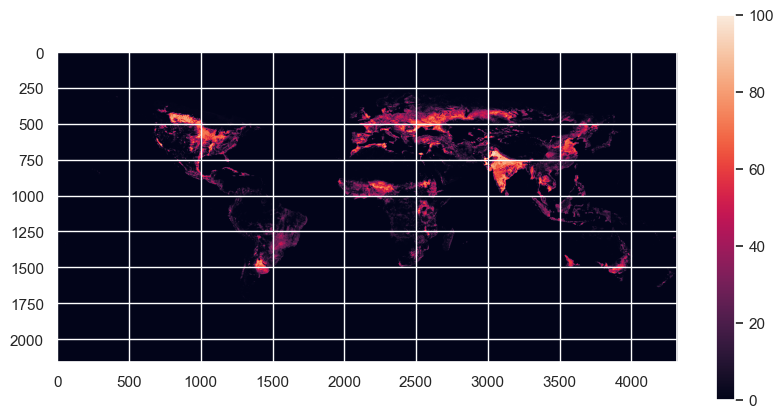

In [65]:
# standard colormaps listed at https://matplotlib.org/stable/tutorials/colors/colormaps.html

darray = np.array(ds.GetRasterBand(1).ReadAsArray())

plt.figure(figsize=(10,5))
plt.imshow(darray) 

# Using an alternative color map...
# plt.imshow(darray, cmap='cool')

plt.colorbar()
plt.show()

### <span style=color:blue>Creating clipped version of cropland.tif using a terminal command and subprocess.</span>

In [58]:
cmd = 'gdal_translate -projwin' 
leftLon = '-3.822042467'
upperLat = '17.05586451'
rightLon = '19.731294237'
lowerLat = '0.907735086'
format = '-of GTiff'
source = '/Users/rick/AG-CODE--v02/GAEZ--v02/cropland.tif'
target = '/Users/rick/AG-CODE--v02/GAEZ--v02/cropland_clipped.tif'

val = " ".join([cmd, leftLon, upperLat, rightLon, lowerLat, format, source, target])
print(val)

result = subprocess.run([val], shell=True, capture_output=True, text=True)

print()
print(result.stdout)
print(result.stderr)


gdal_translate -projwin -3.822042467 17.05586451 19.731294237 0.907735086 -of GTiff /Users/rick/AG-CODE--v02/GAEZ--v02/cropland.tif /Users/rick/AG-CODE--v02/GAEZ--v02/cropland_clipped.tif

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.




### <span style=color:blue>Looking at metadata for cropland_clipped.tif.</span>

In [66]:
dir = "/users/rick/AG-CODE--v02/GAEZ--v02/"
clipped_file_name = "cropland_clipped.tif"

val = " ".join(["gdalinfo", "-json", dir + clipped_file_name])
print(val)
result = subprocess.run([val], shell=True, capture_output=True, text=True)

dict = json.loads(result.stdout)
# print(json.dumps(dict, indent=2, sort_keys=True))

useful = pull_useful(dict)
print(json.dumps(useful, indent=2, sort_keys=True))

gdalinfo -json /users/rick/AG-CODE--v02/GAEZ--v02/cropland_clipped.tif
{
  "bbox": {
    "east_longitude": 180,
    "north_latitude": 90,
    "south_latitude": -90,
    "west_longitude": -180
  },
  "cornerCoordinates": {
    "center": [
      7.9583333,
      9.0
    ],
    "lowerLeft": [
      -3.8333333,
      0.9166667
    ],
    "lowerRight": [
      19.75,
      0.9166667
    ],
    "upperLeft": [
      -3.8333333,
      17.0833333
    ],
    "upperRight": [
      19.75,
      17.0833333
    ]
  },
  "espgEncoding": 4326,
  "proj:transform": [
    -3.833333333333343,
    0.0833333333333333,
    0.0,
    17.083333333333343,
    0.0,
    -0.0833333333333333
  ],
  "size": [
    283,
    194
  ]
}


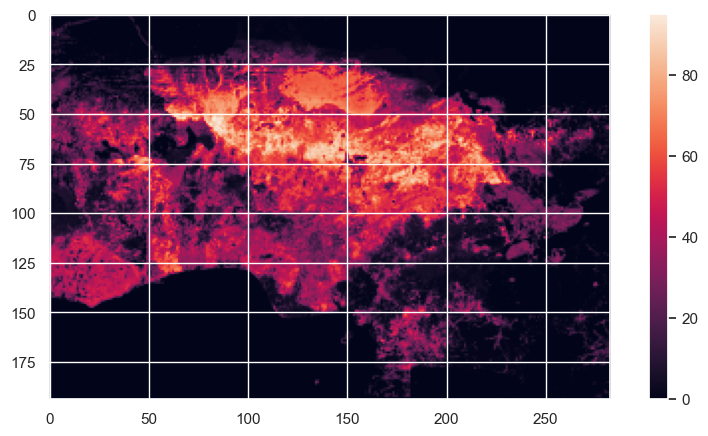

In [68]:
dsc = gdal.Open(dir + clipped_file_name)

dcarray = np.array(dsc.GetRasterBand(1).ReadAsArray())

plt.figure(figsize=(10,5))
plt.imshow(dcarray) 

plt.colorbar()
plt.show()



### <span style=color:blue>Fetching and inspecting Soybean Productivity tif.</span>

In [86]:
soybean_prod_url = 'https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res06/T/2010/soy_2010_prd.tif'

# Local directory to save the TIF file in
dir = "/Users/rick/AG-CODE--v02/GAEZ--v02/"
soy_file_name = "soybean_prod.tif"

# Fetch the TIF file using the URL
urllib.request.urlretrieve(soybean_prod_url, dir + soy_file_name)

val = " ".join(["gdalinfo", "-json", dir + soy_file_name])
print(val)
result = subprocess.run([val], shell=True, capture_output=True, text=True)

dicts = json.loads(result.stdout)
# print(json.dumps(dicts, indent=2, sort_keys=True))

usefuls = pull_useful(dicts)
print(json.dumps(usefuls, indent=2, sort_keys=True))

gdalinfo -json /Users/rick/AG-CODE--v02/GAEZ--v02/soybean_prod.tif
{
  "bbox": {
    "east_longitude": 180,
    "north_latitude": 90,
    "south_latitude": -90,
    "west_longitude": -180
  },
  "cornerCoordinates": {
    "center": [
      0.0,
      0.0
    ],
    "lowerLeft": [
      -180.0,
      -90.0
    ],
    "lowerRight": [
      180.0,
      -90.0
    ],
    "upperLeft": [
      -180.0,
      90.0
    ],
    "upperRight": [
      180.0,
      90.0
    ]
  },
  "espgEncoding": 4326,
  "proj:transform": [
    -180.0,
    0.0833333333333333,
    0.0,
    90.0,
    0.0,
    -0.0833333333333333
  ],
  "size": [
    4320,
    2160
  ]
}


### <span style=color:blue>Creating clipped version of soybean_prod.tif using same coords as with cropland.tif</span>

In [87]:
cmd = 'gdal_translate -projwin' 
leftLon = '-3.822042467'
upperLat = '17.05586451'
rightLon = '19.731294237'
lowerLat = '0.907735086'
format = '-of GTiff'
source = '/Users/rick/AG-CODE--v02/GAEZ--v02/soybean_prod.tif'
target = '/Users/rick/AG-CODE--v02/GAEZ--v02/soybean_prod_clipped.tif'

val = " ".join([cmd, leftLon, upperLat, rightLon, lowerLat, format, source, target])
print(val)

result = subprocess.run([val], shell=True, capture_output=True, text=True)

print()
print(result.stdout)
print(result.stderr)


gdal_translate -projwin -3.822042467 17.05586451 19.731294237 0.907735086 -of GTiff /Users/rick/AG-CODE--v02/GAEZ--v02/soybean_prod.tif /Users/rick/AG-CODE--v02/GAEZ--v02/soybean_prod_clipped.tif

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.




### <span style=color:blue>Inspecting the soybean_prod_cropped.tif.</span>

In [88]:
dir = "/users/rick/AG-CODE--v02/GAEZ--v02/"
soybean_prod_clipped_file_name = "soybean_prod_clipped.tif"

val = " ".join(["gdalinfo", "-json", dir + soybean_prod_clipped_file_name])
print(val)
result = subprocess.run([val], shell=True, capture_output=True, text=True)

dict = json.loads(result.stdout)
# print(json.dumps(dict, indent=2, sort_keys=True))

useful = pull_useful(dict)
print(json.dumps(useful, indent=2, sort_keys=True))

gdalinfo -json /users/rick/AG-CODE--v02/GAEZ--v02/soybean_prod_clipped.tif
{
  "bbox": {
    "east_longitude": 180,
    "north_latitude": 90,
    "south_latitude": -90,
    "west_longitude": -180
  },
  "cornerCoordinates": {
    "center": [
      7.9583333,
      9.0
    ],
    "lowerLeft": [
      -3.8333333,
      0.9166667
    ],
    "lowerRight": [
      19.75,
      0.9166667
    ],
    "upperLeft": [
      -3.8333333,
      17.0833333
    ],
    "upperRight": [
      19.75,
      17.0833333
    ]
  },
  "espgEncoding": 4326,
  "proj:transform": [
    -3.833333333333343,
    0.0833333333333333,
    0.0,
    17.083333333333343,
    0.0,
    -0.0833333333333333
  ],
  "size": [
    283,
    194
  ]
}


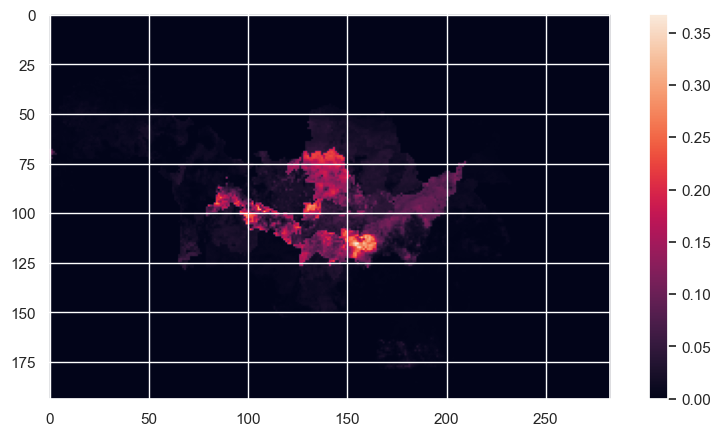

In [90]:

dssb = gdal.Open(dir + soybean_prod_clipped_file_name)

dsbarray = np.array(dssb.GetRasterBand(1).ReadAsArray())


plt.figure(figsize=(10,5))
plt.imshow(dsbarray) 
plt.colorbar()
plt.show()
